# LAB 5. Hypothesis testing. Green taxi case.

## Homework due:  Oct 18, 12 noon

Test varios hypothesis about ridership volume and trip characteristics for green taxi trips in 2019-2020. 

Does the ridership decline over time? Does it depend on the day of the week and time of the day? Does the distribution of the trip parameters (distance, time, speed) depend on the day of the week and borough?

In [2]:
#import the modules
import pandas as pd
import geopandas as gpd
import urllib.request
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
dfTaxi = pd.read_csv('/home/jovyan/shared/Data/greenTaxi1920.csv')
dfTaxi.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,total_amount
0,2019-08-01 00:22:12,2019-08-01 00:22:38,145,145.0,0.00,2.5,3.30
1,2019-08-01 00:11:35,2019-08-01 00:25:53,66,49.0,2.55,11.5,15.36
2,2019-08-01 00:56:09,2019-08-01 01:12:02,65,68.0,4.33,15.5,21.55
3,2019-07-31 23:59:42,2019-08-01 00:11:44,25,133.0,3.85,13.0,16.30
4,2019-08-01 00:20:34,2019-08-01 00:28:44,75,263.0,1.30,7.5,12.55


In [4]:
#take care of the timestamp types
dfTaxi['lpep_pickup_datetime'] = pd.to_datetime(dfTaxi['lpep_pickup_datetime'])
dfTaxi['lpep_dropoff_datetime'] = pd.to_datetime(dfTaxi['lpep_dropoff_datetime'])

In [9]:
#extract date, year, day of the week and hour (takes some time around half a minute)
dfTaxi['Date'] = dfTaxi['lpep_pickup_datetime'].dt.date
dfTaxi['Month'] = dfTaxi['lpep_pickup_datetime'].dt.month
dfTaxi['Year'] = dfTaxi['lpep_pickup_datetime'].dt.year
dfTaxi['DOW'] = dfTaxi['lpep_pickup_datetime'].dt.dayofweek
dfTaxi['Hour'] = dfTaxi['lpep_pickup_datetime'].dt.hour
dfTaxi = dfTaxi.loc[dfTaxi['Year'].isin([2019, 2020])]

In [8]:
dfTaxi.dtypes

lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
PULocationID                      int64
DOLocationID                    float64
trip_distance                   float64
fare_amount                     float64
total_amount                    float64
Date                             object
Month                             int64
Year                              int64
DOW                               int64
Hour                             object
dtype: object

In [5]:
dfTaxi

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,total_amount,Date,Month,Year,DOW,Hour
0,2019-08-01 00:22:12,2019-08-01 00:22:38,145,145.0,0.00,2.5,3.30,2019-08-01,8,2019,3,0
1,2019-08-01 00:11:35,2019-08-01 00:25:53,66,49.0,2.55,11.5,15.36,2019-08-01,8,2019,3,0
2,2019-08-01 00:56:09,2019-08-01 01:12:02,65,68.0,4.33,15.5,21.55,2019-08-01,8,2019,3,0
3,2019-07-31 23:59:42,2019-08-01 00:11:44,25,133.0,3.85,13.0,16.30,2019-07-31,7,2019,2,23
4,2019-08-01 00:20:34,2019-08-01 00:28:44,75,263.0,1.30,7.5,12.55,2019-08-01,8,2019,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6668168,2019-01-31 23:08:27,2019-01-31 23:22:59,255,226.0,3.33,13.0,18.39,2019-01-31,1,2019,3,23
6668169,2019-01-31 23:21:26,2019-01-31 23:23:05,75,151.0,0.72,4.0,6.36,2019-01-31,1,2019,3,23
6668170,2019-01-31 23:30:05,2019-01-31 23:36:14,75,238.0,1.75,7.0,8.30,2019-01-31,1,2019,3,23
6668171,2019-01-31 23:59:58,2019-02-01 00:04:18,74,74.0,0.57,5.0,7.30,2019-01-31,1,2019,3,23


In [6]:
#calculate trip duration in minutes
dfTaxi['trip_duration'] = (dfTaxi['lpep_dropoff_datetime'] - dfTaxi['lpep_pickup_datetime'])
dfTaxi['trip_duration'] = dfTaxi['trip_duration'].dt.total_seconds() / 60

In [7]:
dfTaxi['speed'] = dfTaxi['trip_distance'] / (dfTaxi['trip_duration'] / 60) #avg trip speed in miles per hoiur

In [8]:
len(dfTaxi) #original number of records

6667936

In [9]:
#sanity filtering
dfTaxi = dfTaxi[(dfTaxi.trip_distance < 100)& (dfTaxi.speed <= 80) & (dfTaxi.speed >= 1) & (dfTaxi.trip_duration <= 100) & (dfTaxi.trip_duration >= 1)]
len(dfTaxi) #remaining records

6387664

In [10]:
#daily total trip counts and cumulative duration and distance traveled
dfTaxiDaily = dfTaxi.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
dfTaxiDaily = dfTaxiDaily.sort_values(by='Date')

In [11]:
dfTaxiDaily['speed'] = dfTaxiDaily['trip_distance'] / dfTaxiDaily['trip_duration'] * 60

In [12]:
dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
4,2019,1,1,2019-01-01,14367,192406.050000,53838.05,16.788885
9,2019,1,2,2019-01-02,18005,271232.433333,65944.76,14.587804
14,2019,1,3,2019-01-03,19858,309655.900000,72154.53,13.980912
19,2019,1,4,2019-01-04,21001,319105.950000,74338.68,13.977554
23,2019,1,5,2019-01-05,19386,258513.416667,63392.53,14.713170


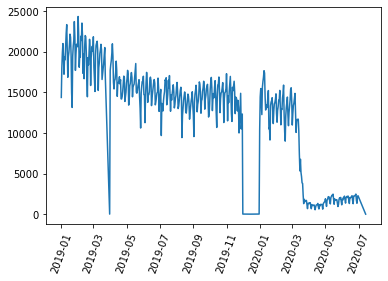

In [13]:
#ridership timeline - daily trip counts; seem to decline and particularly during the pandemics lockdown
plt.plot(dfTaxiDaily['Date'], dfTaxiDaily['trip_count'])
plt.xticks(rotation=70);
plt.show()

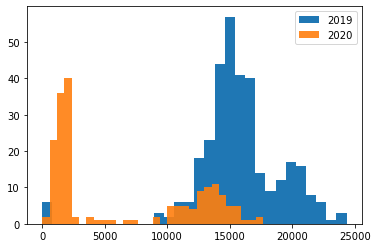

In [14]:
#histograms of daily counts in 2019 and 2020 - distributions look different
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'].values,bins=30,label='2019')
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'].values,bins=30,alpha=0.9,label='2020')
#plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'].values,bins=30,alpha=0.5,label='2020')
plt.legend()

2020 daily ride numbers are vastly different from 2019 numbers, due to the pandemic

In [15]:
## t-test between the 2019 and 2020 distributions
stats.ttest_ind(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'])

Ttest_indResult(statistic=22.879917560620992, pvalue=2.222080562897862e-80)

In [16]:
## K-S test
stats.ks_2samp(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'])

KstestResult(statistic=0.662140364737639, pvalue=8.881784197001252e-16)

So the hypothesis that 2019 and 2020 daily trip counts follow the same distributions can be rejected beyond any reasonable doubt

In [17]:
#For further analysis select the year 2019
dfTaxiDaily2019 = dfTaxiDaily.loc[dfTaxiDaily['Year']==2019] #daily aggregates
dfTaxi2019 = dfTaxi.loc[dfTaxi['Year']==2019] #individual trips
(dfTaxiDaily2019['trip_count'].sum(),len(dfTaxi2019)) #total trip counts in either dataset

(5223051, 5223051)

## Example 1. Test if weekend ridership is different from weekday

In [18]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<4
# t-test
stats.ttest_ind(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<4]['trip_count'])

Ttest_indResult(statistic=-2.972846311995963, pvalue=0.003205266065000704)

In [19]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<4
# KS-test
stats.ks_2samp(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<4]['trip_count'])

KstestResult(statistic=0.24711879432624115, pvalue=0.0006547345365657264)

Reject the hypothesis that weekends and weekdays follow the same ridership distribution at 95\% significance level

## Example 2. Test if trip speed, duration or distance follow log-normal distributions

<AxesSubplot:>

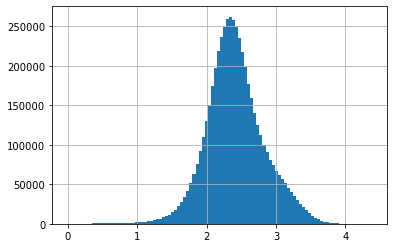

In [20]:
#analyze the overall speed distribution (plot on log-scale)
np.log(dfTaxi2019['speed']).hist(bins=100)

<AxesSubplot:>

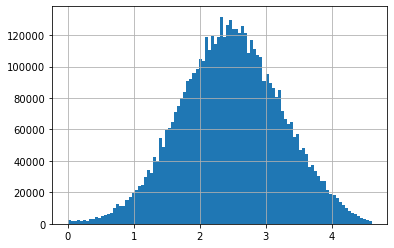

In [21]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_duration']).hist(bins=100)

<AxesSubplot:>

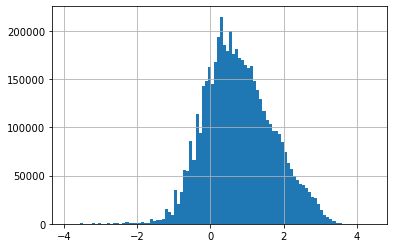

In [22]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_distance']).hist(bins=100)

In [23]:
def is_normal(x): #check is the distribution is normal using one-sample KS test and sample mean-std
    return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [24]:
# is log-speed normally distributed?
is_normal(np.log(dfTaxi2019['speed']))

KstestResult(statistic=0.04036265721868104, pvalue=0.0)

In [25]:
# is log-duration normally distributed?
is_normal(np.log(dfTaxi2019['trip_duration']))

KstestResult(statistic=0.006262974104248364, pvalue=2.230867364609065e-178)

In [26]:
# is log-distance normally distributed?
is_normal(np.log(dfTaxi2019['trip_distance']))

KstestResult(statistic=0.03719595518658181, pvalue=0.0)

In [27]:
#so none of those quantities have log-normal distribution (rejecting with 99.9999...% confidence)

In [28]:
#what about daily average trip_count, duration, distance, speed?

In [29]:
is_normal(dfTaxiDaily2019['trip_count']) #does not look normal

KstestResult(statistic=0.10222090032691844, pvalue=0.0017910702475394608)

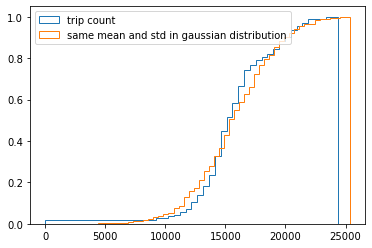

In [30]:
#visualize empiric CDF's for trip-counts
plt.hist(dfTaxiDaily2019['trip_count'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip count')
plt.hist(np.random.normal(dfTaxiDaily2019['trip_count'].mean(), dfTaxiDaily2019['trip_count'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [31]:
is_normal(np.log(dfTaxiDaily2019['trip_count'])) #but might be log-normal

KstestResult(statistic=0.39763352335934615, pvalue=7.316977574996973e-48)

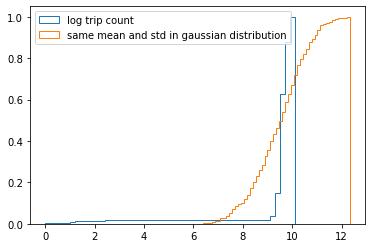

In [32]:
#visualize empiric CDF's for log trip-counts
plt.hist(np.log(dfTaxiDaily2019['trip_count'].values), 50, density=True, 
         histtype='step',cumulative=True,label='log trip count')
plt.hist(np.random.normal(np.log(dfTaxiDaily2019['trip_count']).mean(), np.log(dfTaxiDaily2019['trip_count']).std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [33]:
is_normal(dfTaxiDaily2019['trip_duration']) #could be normal

KstestResult(statistic=0.05949038815352092, pvalue=0.18313344866656922)

<AxesSubplot:>

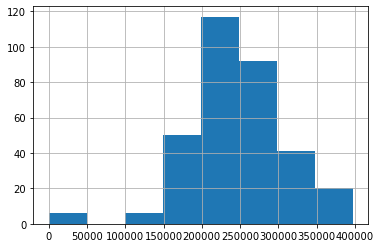

In [34]:
dfTaxiDaily2019['trip_duration'].hist(bins=8)

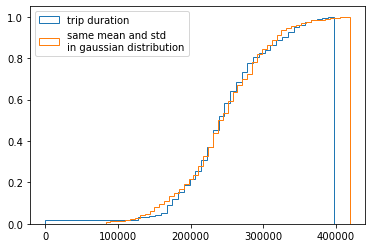

In [35]:
_ = plt.hist(dfTaxiDaily2019['trip_duration'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip duration')
_ = plt.hist(np.random.normal(dfTaxiDaily2019['trip_duration'].mean(), 
                              dfTaxiDaily2019['trip_duration'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std \nin gaussian distribution')
plt.legend(loc='upper left')

In [36]:
is_normal(dfTaxiDaily2019['trip_distance']) #does not look normal

KstestResult(statistic=0.10000823433973582, pvalue=0.0024171269598154545)

In [37]:
is_normal(np.log(dfTaxiDaily2019['trip_distance'])) #but might be log-normal

KstestResult(statistic=0.4018549402287594, pvalue=6.470437360887711e-49)

In [38]:
is_normal(dfTaxiDaily2019['speed']) #might be normal

KstestResult(statistic=0.051326846636975176, pvalue=0.3345668864594482)

In [39]:
is_normal(np.log(dfTaxiDaily2019['speed'])) #log-normal even more likely

KstestResult(statistic=0.055849494322260204, pvalue=0.24242825588781025)

## Research questions to further explore
- Which weekdays are similar/different in terms of avg.travel speed distributions?
- Are evening/morning/afternoon trip speed, duration and distance distributions signifiantly different?
- Are trip speed, duration and distance distributions different in Brooklyn vs Queens or Bronx? 
- No doubt that 2020 saw a large drop in ridership but how can we assess it? As we don't have the full year, the drop just started in March and there is also a general decline, consider the 2020/2019 ratios (to account for the general trend and seasonality and see how much more steep is the drop during the pandemics). Compare the pandemics numbers (After March 2020 with the same period pre-march 2020). Also compare the post-pandemics and pre-pandemics travel distance, speed and duration distributions

## Homework assignment

## Task 1. Travel speed - hours of the day (2 pts)
Traffic and travel speed might vary throughout the day. Select the trips happening on Oct, 1, 2019. a) Compute average travel speed per each hour of the day and visuale as a bar plot. Compare the speed distributions for: b) trip samples within an hour of 9am (Hour=9) and an hour of 10am, c) morning rush hour (two hours of 8 and 9am) and evening rush hour (two hours of 5pm(17) and 6pm(18)). Can you reject the hypothesis that the compared speed samples have the same mean(use t-test) and distribution (use ks-test) at a 95\% significance level?

In [40]:
# YOUR CODE HERE
#raise NotImplementedError()
dfTaxi

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,total_amount,Date,Month,Year,DOW,Hour,trip_duration,speed
1,2019-08-01 00:11:35,2019-08-01 00:25:53,66,49.0,2.55,11.5,15.36,2019-08-01,8,2019,3,0,14.300000,10.699301
2,2019-08-01 00:56:09,2019-08-01 01:12:02,65,68.0,4.33,15.5,21.55,2019-08-01,8,2019,3,0,15.883333,16.356768
3,2019-07-31 23:59:42,2019-08-01 00:11:44,25,133.0,3.85,13.0,16.30,2019-07-31,7,2019,2,23,12.033333,19.196676
4,2019-08-01 00:20:34,2019-08-01 00:28:44,75,263.0,1.30,7.5,12.55,2019-08-01,8,2019,3,0,8.166667,9.551020
5,2019-08-01 00:29:16,2019-08-01 00:46:21,65,198.0,5.25,17.5,20.80,2019-08-01,8,2019,3,0,17.083333,18.439024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6668168,2019-01-31 23:08:27,2019-01-31 23:22:59,255,226.0,3.33,13.0,18.39,2019-01-31,1,2019,3,23,14.533333,13.747706
6668169,2019-01-31 23:21:26,2019-01-31 23:23:05,75,151.0,0.72,4.0,6.36,2019-01-31,1,2019,3,23,1.650000,26.181818
6668170,2019-01-31 23:30:05,2019-01-31 23:36:14,75,238.0,1.75,7.0,8.30,2019-01-31,1,2019,3,23,6.150000,17.073171
6668171,2019-01-31 23:59:58,2019-02-01 00:04:18,74,74.0,0.57,5.0,7.30,2019-01-31,1,2019,3,23,4.333333,7.892308


In [41]:
# Select the trips happening on Oct, 1, 2019. 
dfTaxi.dtypes

lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
PULocationID                      int64
DOLocationID                    float64
trip_distance                   float64
fare_amount                     float64
total_amount                    float64
Date                             object
Month                             int64
Year                              int64
DOW                               int64
Hour                              int64
trip_duration                   float64
speed                           float64
dtype: object

In [42]:
dfTaxi['Date_str']=dfTaxi['Date'].astype(str)
dfTaxi

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,total_amount,Date,Month,Year,DOW,Hour,trip_duration,speed,Date_str
1,2019-08-01 00:11:35,2019-08-01 00:25:53,66,49.0,2.55,11.5,15.36,2019-08-01,8,2019,3,0,14.300000,10.699301,2019-08-01
2,2019-08-01 00:56:09,2019-08-01 01:12:02,65,68.0,4.33,15.5,21.55,2019-08-01,8,2019,3,0,15.883333,16.356768,2019-08-01
3,2019-07-31 23:59:42,2019-08-01 00:11:44,25,133.0,3.85,13.0,16.30,2019-07-31,7,2019,2,23,12.033333,19.196676,2019-07-31
4,2019-08-01 00:20:34,2019-08-01 00:28:44,75,263.0,1.30,7.5,12.55,2019-08-01,8,2019,3,0,8.166667,9.551020,2019-08-01
5,2019-08-01 00:29:16,2019-08-01 00:46:21,65,198.0,5.25,17.5,20.80,2019-08-01,8,2019,3,0,17.083333,18.439024,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6668168,2019-01-31 23:08:27,2019-01-31 23:22:59,255,226.0,3.33,13.0,18.39,2019-01-31,1,2019,3,23,14.533333,13.747706,2019-01-31
6668169,2019-01-31 23:21:26,2019-01-31 23:23:05,75,151.0,0.72,4.0,6.36,2019-01-31,1,2019,3,23,1.650000,26.181818,2019-01-31
6668170,2019-01-31 23:30:05,2019-01-31 23:36:14,75,238.0,1.75,7.0,8.30,2019-01-31,1,2019,3,23,6.150000,17.073171,2019-01-31
6668171,2019-01-31 23:59:58,2019-02-01 00:04:18,74,74.0,0.57,5.0,7.30,2019-01-31,1,2019,3,23,4.333333,7.892308,2019-01-31


In [43]:
oct_2019=dfTaxi[dfTaxi['Date_str']== '2019-10-01']
oct_2019

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,total_amount,Date,Month,Year,DOW,Hour,trip_duration,speed,Date_str
839374,2019-10-01 00:02:03,2019-10-01 00:03:34,166,166.0,0.36,3.50,4.80,2019-10-01,10,2019,1,0,1.516667,14.241758,2019-10-01
839576,2019-10-01 00:02:07,2019-10-01 00:12:34,130,205.0,2.85,11.00,12.30,2019-10-01,10,2019,1,0,10.450000,16.363636,2019-10-01
839614,2019-10-01 00:00:05,2019-10-01 00:05:50,256,37.0,1.21,6.50,9.36,2019-10-01,10,2019,1,0,5.750000,12.626087,2019-10-01
2124647,2019-10-01 00:26:02,2019-10-01 00:39:58,112,196.0,5.88,18.00,19.30,2019-10-01,10,2019,1,0,13.933333,25.320574,2019-10-01
2124648,2019-10-01 00:18:11,2019-10-01 00:22:38,43,263.0,0.80,5.00,9.05,2019-10-01,10,2019,1,0,4.450000,10.786517,2019-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513732,2019-10-01 23:23:00,2019-10-02 00:00:00,61,42.0,16.53,46.75,50.00,2019-10-01,10,2019,1,23,37.000000,26.805405,2019-10-01
2513733,2019-10-01 23:07:00,2019-10-01 23:39:00,205,195.0,19.00,55.88,59.13,2019-10-01,10,2019,1,23,32.000000,35.625000,2019-10-01
2513734,2019-10-01 23:29:00,2019-10-01 23:51:00,42,158.0,7.36,37.28,40.53,2019-10-01,10,2019,1,23,22.000000,20.072727,2019-10-01
2513735,2019-10-01 23:02:00,2019-10-01 23:21:00,53,38.0,13.01,30.84,34.09,2019-10-01,10,2019,1,23,19.000000,41.084211,2019-10-01


In [44]:
#a) Compute average travel speed per each hour of the day and visuale as a bar plot.
oct_2019_2=oct_2019.groupby(['Hour']). agg({'speed':'mean'}).rename(columns={'speed': 'AVG_speed'}).reset_index()
oct_2019_2

,Hour,AVG_speed
0,0,15.462158
1,1,15.006791
2,2,15.089092
3,3,16.959088
4,4,20.315675
5,5,21.163462
6,6,16.589186
7,7,13.306396
8,8,12.561804
9,9,12.717549


<AxesSubplot:title={'center':'Average travel speed per each hour of the day'}, xlabel='Hour'>

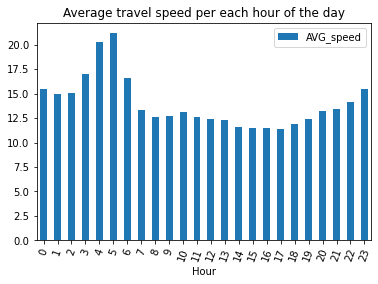

In [45]:
oct_2019_2.plot.bar(x="Hour", y="AVG_speed", rot=70, title='Average travel speed per each hour of the day')

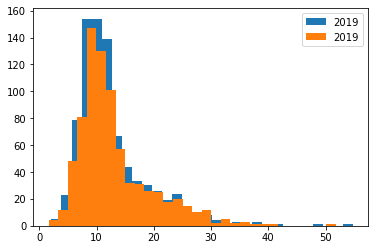

In [46]:
#Compare the speed distributions for: b) trip samples within an hour of 9am (Hour=9) and an hour of 10am
##histograms of speed distributions for trip samples within an hour of 9am (Hour=9) and an hour of 10am
plt.hist(oct_2019.loc[oct_2019['Hour'] == 9]['speed'].values,bins=30,label='2019')
plt.hist(oct_2019.loc[oct_2019['Hour'] == 10]['speed'].values,bins=30,label='2019')
plt.legend()

In [47]:
#speed distributions for trip samples within an hour of 9am (Hour=9) and an hour of 10am looks slighly differet
## t-test between hour of 9am (Hour=9) and an hour of 10am distributions
stats.ttest_ind(oct_2019.loc[oct_2019['Hour'] == 9]['speed'],oct_2019.loc[oct_2019['Hour'] == 10]['speed'])

Ttest_indResult(statistic=-1.173277394807621, pvalue=0.2408567402829922)

In [48]:
## K-S test
stats.ks_2samp(oct_2019.loc[oct_2019['Hour'] == 9]['speed'],oct_2019.loc[oct_2019['Hour'] == 10]['speed'])

KstestResult(statistic=0.04866545344252351, pvalue=0.2793212653142807)

In [49]:
#YES! we can reject the hypothesis that the compared speed samples have the same mean and distribution at a 95% significance level.
#As p-values and ks-values are less than 0.5

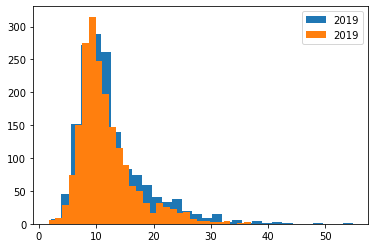

In [50]:
#c) morning rush hour (two hours of 8 and 9am) and evening rush hour (two hours of 5pm(17) and 6pm(18))
##histograms of speed distributions for morning rush hour (two hours of 8 and 9am) and evening rush hour (two hours of 5pm(17) and 6pm(18))
plt.hist(oct_2019.loc[((oct_2019['Hour'] == 8) | (oct_2019['Hour'] == 9))]['speed'].values,bins=30,label='2019')
plt.hist(oct_2019.loc[((oct_2019['Hour'] == 17) | (oct_2019['Hour'] == 18))]['speed'].values,bins=30,label='2019')
plt.legend()

In [51]:
## t-test for morning rush hour (two hours of 8 and 9am) and evening rush hour (two hours of 5pm(17) and 6pm(18))
stats.ttest_ind(oct_2019.loc[((oct_2019['Hour'] == 8) | (oct_2019['Hour'] == 9))]['speed'], oct_2019.loc[((oct_2019['Hour'] == 17) | (oct_2019['Hour'] == 18))]['speed'])

Ttest_indResult(statistic=5.316218844376528, pvalue=1.1253493376433041e-07)

In [52]:
## K-S test
stats.ks_2samp(oct_2019.loc[((oct_2019['Hour'] == 8) | (oct_2019['Hour'] == 9))]['speed'], oct_2019.loc[((oct_2019['Hour'] == 17) | (oct_2019['Hour'] == 18))]['speed'])

KstestResult(statistic=0.06860517517057287, pvalue=0.0005164093592973096)

In [53]:
#Can you reject the hypothesis that the compared speed samples have the same mean(use t-test) and distribution (use ks-test) at a 95% significance level?

#YES! we can reject the hypothesis that the compared speed samples have the same mean and distribution at a 95% significance level.
#As p-values and ks-values are less than 0.05

## Task 2. Travel speed - days of the week (2 pts)
Traffic and travel speed also vary during different weekdays. a) Compute average travel speed per each of the 7 days of the week (among all the individual trips happening on Mondays, Tuesdays, Wednesdays etc); visualize those as a bar plot. Then compute average travel speed per each day of the year and perform a pairwise comparison between the distributions of the daily speed averages within different days of the week (i.e. distribution of all Mondays vs all Tuesdays etc). Compute p-value of the ks-test for each pair of the different weekdays and compare with 5\%. As a results we are expecting a 7*7 pandas dataframe filled with "reject" (if p-value below 5\%), "keep" (if p-value above 5\%) and "-" on the diagonal.

In [54]:
# YOUR CODE HERE
dfTaxi

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,total_amount,Date,Month,Year,DOW,Hour,trip_duration,speed,Date_str
1,2019-08-01 00:11:35,2019-08-01 00:25:53,66,49.0,2.55,11.5,15.36,2019-08-01,8,2019,3,0,14.300000,10.699301,2019-08-01
2,2019-08-01 00:56:09,2019-08-01 01:12:02,65,68.0,4.33,15.5,21.55,2019-08-01,8,2019,3,0,15.883333,16.356768,2019-08-01
3,2019-07-31 23:59:42,2019-08-01 00:11:44,25,133.0,3.85,13.0,16.30,2019-07-31,7,2019,2,23,12.033333,19.196676,2019-07-31
4,2019-08-01 00:20:34,2019-08-01 00:28:44,75,263.0,1.30,7.5,12.55,2019-08-01,8,2019,3,0,8.166667,9.551020,2019-08-01
5,2019-08-01 00:29:16,2019-08-01 00:46:21,65,198.0,5.25,17.5,20.80,2019-08-01,8,2019,3,0,17.083333,18.439024,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6668168,2019-01-31 23:08:27,2019-01-31 23:22:59,255,226.0,3.33,13.0,18.39,2019-01-31,1,2019,3,23,14.533333,13.747706,2019-01-31
6668169,2019-01-31 23:21:26,2019-01-31 23:23:05,75,151.0,0.72,4.0,6.36,2019-01-31,1,2019,3,23,1.650000,26.181818,2019-01-31
6668170,2019-01-31 23:30:05,2019-01-31 23:36:14,75,238.0,1.75,7.0,8.30,2019-01-31,1,2019,3,23,6.150000,17.073171,2019-01-31
6668171,2019-01-31 23:59:58,2019-02-01 00:04:18,74,74.0,0.57,5.0,7.30,2019-01-31,1,2019,3,23,4.333333,7.892308,2019-01-31


In [55]:
#a) Compute average travel speed per each of the 7 days of the week (among all the individual trips happening on Mondays, Tuesdays, Wednesdays etc)
avg_travel_speed_7days= dfTaxi.groupby(['DOW']). agg({'speed':'mean'}).rename(columns={'speed': 'AVG_speed'}).reset_index()
avg_travel_speed_7days

,DOW,AVG_speed
0,0,12.541322
1,1,12.224553
2,2,12.107320
3,3,11.911794
4,4,11.825660
5,5,12.850901
6,6,13.625362


<AxesSubplot:title={'center':'Average travel speed per each of the 7 days of the week'}, xlabel='DOW'>

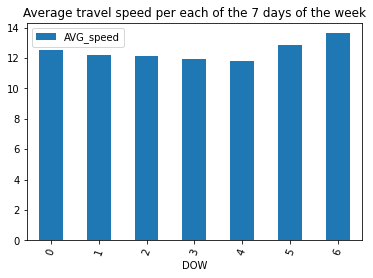

In [56]:
#visualize those as a bar plot. 
avg_travel_speed_7days.plot.bar( x="DOW", y="AVG_speed", rot=70, title='Average travel speed per each of the 7 days of the week')

In [57]:
#Then compute average travel speed per each day of the year and perform a pairwise comparison between the distributions 
#of the daily speed averages within different days of the week (i.e. distribution of all Mondays vs all Tuesdays etc). 
avg_travel_speed_eachdayofyear= dfTaxi.groupby(['DOW', 'Date']). agg({'speed':'mean'}).rename(columns={'speed': 'AVG_speed'}).reset_index()
avg_travel_speed_eachdayofyear

,DOW,Date,AVG_speed
0,0,2019-01-07,12.575642
1,0,2019-01-14,12.352215
2,0,2019-01-21,14.117442
3,0,2019-01-28,12.528519
4,0,2019-02-04,12.391450
...,...,...,...
510,6,2020-05-31,17.734391
511,6,2020-06-07,18.271584
512,6,2020-06-14,17.030476
513,6,2020-06-21,17.074598


In [58]:
list(set(avg_travel_speed_eachdayofyear.DOW.unique()))

[0, 1, 2, 3, 4, 5, 6]

In [59]:
#As a results we are expecting a 7*7 pandas dataframe filled with "reject" (if p-value below 5%), 
#"keep" (if p-value above 5%) and "-" on the diagonal.
from scipy.stats import ttest_ind
df = avg_travel_speed_eachdayofyear
DOW = list(set(avg_travel_speed_eachdayofyear.DOW.unique()))
lst = []
for a in DOW:
    for b in DOW:
        c =''
        ser1 = avg_travel_speed_eachdayofyear.loc[avg_travel_speed_eachdayofyear['DOW'] == a,'AVG_speed']
        ser2 = avg_travel_speed_eachdayofyear.loc[avg_travel_speed_eachdayofyear['DOW'] == b, 'AVG_speed']
        t,p = stats.ks_2samp(ser1,ser2)

        lst.append([a, b, p])
        
temp2 = pd.DataFrame(lst, columns = ['DOW1','DOW2','p'])
temp2

temp3 = pd.pivot_table(temp2, values = 'p', index='DOW1', columns = 'DOW2')

temp3.index.name = None
temp3

for i in range(temp3.shape[1]):
    for j in range(temp3.shape[0]):
        if i == j:
            temp3.loc[i,j] = '-'
        elif temp3.loc[i,j] < 0.05:
            temp3.loc[i,j] = 'Reject'
        else:
            temp3.loc[i,j] = "Keep"
temp3       

DOW2,0,1,2,3,4,5,6
0,-,Keep,Reject,Reject,Reject,Reject,Reject
1,Keep,-,Keep,Reject,Reject,Reject,Reject
2,Reject,Keep,-,Keep,Reject,Reject,Reject
3,Reject,Reject,Keep,-,Keep,Reject,Reject
4,Reject,Reject,Reject,Keep,-,Reject,Reject
5,Reject,Reject,Reject,Reject,Reject,-,Reject
6,Reject,Reject,Reject,Reject,Reject,Reject,-


## Task 3. Trip speeds per borough. (3 pts)

For the day of Oct, 1, 2019 compute the average trip speed in Brooklyn, Queens and Bronx (by pickup). Then compare the samples of the trip speeds in Brooklyn, Queens and Bronx on that day using t-test and ks-test (pairwise comparison). Fill two 3x3 pandas dataframes (one for t-test, one for ks-test) with p-values for each pair of boroughs. Can we reject the null hypothesis that speed mean/distributions within each pair of boroughs is similar?

In [60]:
taxizone = gpd.read_file('/home/jovyan/shared/Data/taxizone.geojson')
taxizone.head(10)

,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,0.0007823067885,1,0.116357453189,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ..."
1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ..."
3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ..."
5,0.000606460984581,6,0.150490542523,6,Arrochar/Fort Wadsworth,Staten Island,"MULTIPOLYGON (((-74.06367 40.60220, -74.06351 ..."
6,0.000389787989274,7,0.107417171123,7,Astoria,Queens,"MULTIPOLYGON (((-73.90414 40.76752, -73.90325 ..."
7,0.000026587716279,8,0.0275906911574,8,Astoria Park,Queens,"MULTIPOLYGON (((-73.92334 40.77513, -73.92398 ..."
8,0.000338443803197,9,0.0997840924705,9,Auburndale,Queens,"MULTIPOLYGON (((-73.78502 40.76104, -73.78486 ..."
9,0.0000607235737749,24,0.0469999619287,24,Bloomingdale,Manhattan,"MULTIPOLYGON (((-73.95954 40.79872, -73.96004 ..."


In [61]:
taxizone['location_id']=taxizone.location_id.astype(int)

In [62]:
taxizone.dtypes

shape_area       object
objectid         object
shape_leng       object
location_id       int64
zone             object
borough          object
geometry       geometry
dtype: object

In [63]:
# YOUR CODE HERE
taxizone.shape

(263, 7)

In [ ]:
oct_1_2019_merge = taxizone.merge(dfTaxi,left_on='location_id',right_on='PULocationID',how='left')
oct_1_2019_merge

In [ ]:
oct_1_2019_merge.columns

In [ ]:
oct_1_2019_merge1=oct_1_2019_merge.loc[((oct_1_2019_merge['borough']=='Brooklyn') | (oct_1_2019_merge['borough']=='Queens') |(oct_1_2019_merge['borough']=='Bronx')) & (oct_1_2019_merge['Date_str']=='2019-10-01')]
oct_1_2019_merge1

In [ ]:
#For the day of Oct, 1, 2019 compute the average trip speed in Brooklyn, Queens and Bronx (by pickup).
oct_1_2019_merge2= oct_1_2019_merge1.groupby(['borough']). agg({'speed':'mean'}).rename(columns={'speed': 'AVG_speed'}).reset_index()
oct_1_2019_merge2

In [ ]:
temp1 = oct_1_2019_merge1[['borough','speed']]
temp1

In [ ]:
#compare the samples of the trip speeds in Brooklyn, Queens and Bronx on that day using t-test and ks-test (pairwise comparison).
#t-test (pairwise comparison)
from scipy.stats import ttest_ind
bor = ['Bronx','Brooklyn','Queens']
lst = []
for a in bor:
    for b in bor:
        print(a,b)
        ser1 = temp1.loc[temp1['borough'] == a,'speed']
        ser2 = temp1.loc[temp1['borough'] == b, 'speed']
        t,p = stats.ttest_ind(ser1,ser2)
        lst.append([a, b, p])
        
temp2 = pd.DataFrame(lst, columns = ['b1','b2','p'])
temp2

temp3 = pd.pivot_table(temp2, values = 'p', index='b1', columns = 'b2')
temp3.index.name = None
temp3

In [ ]:
# ks-test (pairwise comparison). 
from scipy.stats import ttest_ind
bor = ['Bronx','Brooklyn','Queens']
lst = []
for a in bor:
    for b in bor:
        print(a,b)
        ser1 = temp1.loc[temp1['borough'] == a,'speed']
        ser2 = temp1.loc[temp1['borough'] == b, 'speed']
        t,p = stats.ks_2samp(ser1,ser2)
        lst.append([a, b, p])
        
temp2 = pd.DataFrame(lst, columns = ['b1','b2','p'])
temp2

temp3 = pd.pivot_table(temp2, values = 'p', index='b1', columns = 'b2')
temp3.index.name = None
temp3

In [ ]:
#Can we reject the null hypothesis that speed mean/distributions within each pair of boroughs is similar?
#YES! we can reject the hypothesis that peed mean/distributions within each pair of boroughs is similar at a 95% significance level.
#As p-values and ks-values are less than 0.5